# Boundary conditions

In [1]:
import numpy as np
import scipy as sp
import os
import sys
from scipy import optimize
from scipy import integrate
from scipy import interpolate
from matplotlib import pyplot as plt

## Import model

In [2]:
#current_dir = os.path.dirname(os.path.abspath(__file__))
#model_directory = os.path.join(current_dir, '..', 'cosmotransition_z2sb', 'cosmoTransitions')
model_directory='/Users/quarkquartet/Work/Wall-velocity/model/'
sys.path.append(model_directory)
import baseMo_s_b_d as bm

In [3]:
m = bm.model(702.654702269, -102.146250858, 0.112009439661, 0.0037322807528, -0.0370639674565,10000)

In [4]:
m.findAllTransitions()

Tracing phase starting at x = [246.00000051 572.58176356] ; t = 0.0
Tracing minimum up
traceMinimum t0 = 0
...........................................................................................................................................................................
Tracing phase starting at x = [-2.27347289e-07  1.79312356e+02] ; t = 68.27354525855334
Tracing minimum down
traceMinimum t0 = 68.2735
..............................................................................
Tracing minimum up
traceMinimum t0 = 68.2735
..............................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[{'low_vev': array([202.04374412, 482.78409962]),
  'high_vev': array([9.51180104e-06, 1.78261369e+02]),
  'Tnuc': 61.79608446346483,
  'low_phase': 0,
  'high_phase': 1,
  'instanton': fullTunneling_rval(profile1D=Profile1D(R=array([0.00000000e+00, 1.04060051e-05, 1.88910615e-03, 3.76780630e-03,
         5.64650644e-03, 7.52520659e-03, 9.40390674e-03, 1.12826069e-02,
         1.31613070e-02, 1.50400072e-02, 1.69187073e-02, 1.87974075e-02,
         2.06761076e-02, 2.25548078e-02, 2.44335079e-02, 2.63122081e-02,
         2.81909082e-02, 3.00696083e-02, 3.19483085e-02, 3.38270086e-02,
         3.57057088e-02, 3.75844089e-02, 3.94631091e-02, 4.13418092e-02,
         4.32205094e-02, 4.50992095e-02, 4.69779097e-02, 4.88566098e-02,
         5.07353100e-02, 5.26140101e-02, 5.44927102e-02, 5.63714104e-02,
         5.82501105e-02, 6.01288107e-02, 6.20075108e-02, 6.38862110e-02,
         6.57649111e-02, 6.76436113e-02, 6.95223114e-02, 7.14010116e-02,
         7.32797117e-02, 7.51584118e-02, 7.70

In [37]:
m.TnTrans[0].keys()

dict_keys(['low_vev', 'high_vev', 'Tnuc', 'low_phase', 'high_phase', 'instanton', 'action', 'trantype', 'crit_trans', 'rho+', 'rho-', 'p+', 'p-', 'ep+', 'ep-'])

In [6]:
hv = m.TnTrans[0]['high_vev']
lv = m.TnTrans[0]['low_vev']
Tnuc = m.TnTrans[0]['Tnuc']
Vtot = m.Vtot

## Thermodynamic quantities

In [7]:
def derivative(f, x, eps=1e-5, order=1):
    """Calculate the derivative of a function.
    Using Ridders algorithm.
    Calculate up to order x**4.
    Only compute 1st or 2nd order derivative."""
    assert (
        order == 1 or order == 2
    ), "Calculate derivative up to an order, must be 1 or 2."
    δx = x * eps
    if order == 1:
        return (f(x - 2 * δx) - 8 * f(x - δx) + 8 * f(x + δx) - f(x + 2 * δx)) / (
            12 * δx
        )
    if order == 2:
        return (f(x - 2 * δx) - f(x - δx) - f(x + δx) + f(x + 2 * δx)) / (3 * δx**2)

In [8]:
def cs_sq(V,T, vev):
    """Sound speed square."""
    def VT(T):
        return V(vev,T)
    return derivative(VT, T, order=1)/(T*derivative(VT, T, order=2))

In [9]:
cs_sq(Vtot, Tnuc, hv)

0.33379900900581405

In [10]:
cs_sq(Vtot, Tnuc,lv)

0.29347226243359037

In [11]:
def epsilon(V,T,vev):
    """Epsilon."""
    def VT(T):
        return V(vev,T)
    return - 0.25*T*derivative(VT,T) + VT(T)

In [12]:
def a(V,T, vev):
    """The parameter a, means the effective dofs."""
    def VT(T):
        return V(vev,T)
    return - 0.75 * derivative(VT,T)/T**3

In [13]:
def alpha_p(V, Tp, Tm, high_vev, low_vev):
    return (epsilon(V,Tp,high_vev) - epsilon(V,Tm, low_vev))/(a(V,Tp, high_vev) * Tp**4)

In [14]:
def r_func(V,Tp,Tm, high_vev, low_vev):
    return a(V,Tp, high_vev)*Tp**4/(a(V,Tm, low_vev)*Tm**4)

In [174]:
def w(V, T, vev):
    def VT(T):
        return V(vev, T)
    return - T * derivative(VT,T)

In [48]:
epsilon(m.Vtot,m.TnTrans[0]['Tnuc'], m.TnTrans[0]['low_vev'])

-13250675.64721587

In [49]:
epsilon(m.Vtot,m.TnTrans[0]['Tnuc'], m.TnTrans[0]['high_vev'])

-1001338.1690678224

In [53]:
alpha_p(m.Vtot,61.95, 61.0, m.TnTrans[0]['high_vev'], m.TnTrans[0]['low_vev'])

0.09631938161494871

## Solve detonation

In [15]:
def match(vp,vm,Tp,Tm, high_vev, low_vev):
    r = r_func(Vtot, Tp, Tm, high_vev, low_vev)
    αp = alpha_p(Vtot, Tp, Tm, high_vev, low_vev)
    vpvm = 1-(1-3*αp)*r
    vpvm = vpvm/(3-3*(1+αp)*r)
    ratio = 3 + (1-3*αp)*r
    ratio = ratio/(1+3*(1+αp)*r)
    return [vp*vm - vpvm, vp/vm - ratio]

In [16]:
match(0.7,0.5,61.8, 61.0, hv,lv)

[0.37488767629163944, 0.676399039862079]

In [17]:
def guess_det(vp, Tp, ap, am, εp, εm):
    αp = (εp-εm)/(ap*Tp**4)
    r=1/(1+3*αp)
    Tm = (ap*Tp**4/(am*r))**0.25
    vpvm = 1-(1-3*αp)*r
    vpvm = vpvm/(3-3*(1+αp)*r)
    vm = min(vpvm/vp, 0.67)
    return [vm,Tm]

In [18]:
def vJ(alphap):
    v = (alphap*(2+3*alphap))**0.5 + 1
    v = v/((1+alphap)*3**0.5)
    return v

In [24]:
vJ(0.050858596835864606)

0.7311924971667051

In [21]:
vw=0.6
guess = guess_det(vw, m.TnTrans[0]['Tnuc'],a(m.Vtot,  m.TnTrans[0]['Tnuc'], m.TnTrans[0]['high_vev']), a(m.Vtot,m.TnTrans[0]['Tnuc']*1.1,m.TnTrans[0]['low_vev']),epsilon(m.Vtot, m.TnTrans[0]['Tnuc'], m.TnTrans[0]['high_vev']), epsilon(m.Vtot, m.TnTrans[0]['Tnuc'], m.TnTrans[0]['low_vev']))
print(guess)
optimize.fsolve(lambda x:match(vw, x[0], m.TnTrans[0]['Tnuc'], x[1], m.TnTrans[0]['high_vev'], m.TnTrans[0]['low_vev']),guess, xtol=1e-10)

[0.67, 69.4428590655021]


/Users/quarkquartet/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


array([ 0.40596061, 81.51196995])

In [18]:
optimize.fsolve(lambda x:match(0.7, x[0], m.TnTrans[0]['Tnuc'], x[1], m.TnTrans[0]['high_vev'], m.TnTrans[0]['low_vev']),guess, xtol=1e-10)

/Users/quarkquartet/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


array([ 0.50929031, 78.62803497])

## Solve deflagration

Try to solve the deflagration solution with vw = 0.5

In [20]:
guess_sol = optimize.fsolve(lambda x:match(x[0],0.5,x[1], 60, hv, lv),[0.3, Tnuc], xtol=1e-10)
guess_sol

array([ 0.31077114, 66.30557572])

In [21]:
def dYda(tau, y, *args):
    """Y: (v, xi, T)"""
    v = y[0]
    xi = y[2]
    T = y[1]
    V=args[0]
    vev=args[1]
    dvdtau = 2 * v * cs_sq(V, T, vev) * (1-v**2) * (1- xi * v)
    dxidtau = xi *((xi-v)**2 - cs_sq(V,T,vev) * (1-xi*v)**2)
    dvdxi = 2*v/xi * (1-v**2)
    dvdxi = dvdxi/(1-v*xi)/(μ(xi, v)**2/cs_sq(V,T,vev) - 1)
    dTdxi = T * μ(xi, v) * dvdxi / (1-v**2)
    dTdtau = dTdxi * dxidtau
    return np.array([dvdtau, dTdtau, dxidtau])

def μ(x, v):
    return (x-v)/(1-x*v)


In [23]:
vsol=integrate.solve_ivp(dYda, (10,1), np.array([μ(0.5, guess_sol[0]), guess_sol[1], 0.5]),t_eval=np.linspace(10,1,1000),method='DOP853', args=(Vtot,hv))

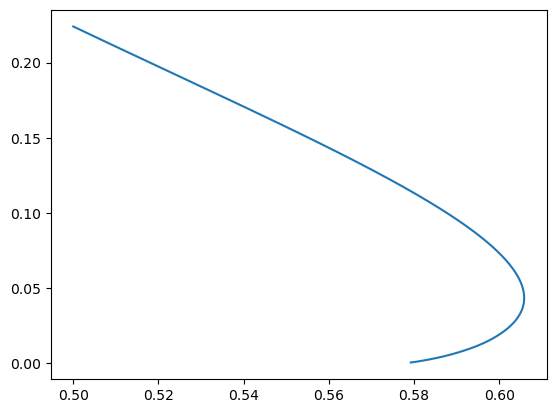

In [25]:
plt.plot(vsol.y[2],vsol.y[0])

In [28]:
xi_max = vsol.y[2].max()
xi_max_index = vsol.y[2].argmax()
v_prof = interpolate.interp1d(vsol.y[2][0:xi_max_index+1], vsol.y[0][0:xi_max_index+1], kind='cubic')
T_prof = interpolate.interp1d(vsol.y[2][0:xi_max_index+1], vsol.y[1][0:xi_max_index+1], kind='cubic')

In [29]:
xi_max

0.605831301288266

In [30]:
vsol.t[xi_max_index]

7.342342342342342

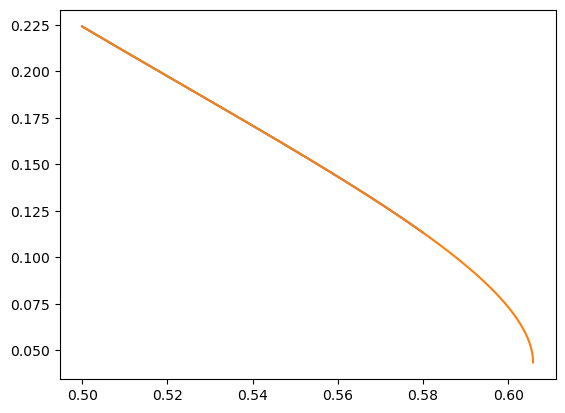

In [31]:
xplot = np.linspace(0.5, 0.58, 100)
vplot = [v_prof(x) for x in xplot]
plt.plot(xplot, vplot)
plt.plot(vsol.y[2][0:xi_max_index+1],vsol.y[0][0:xi_max_index+1])

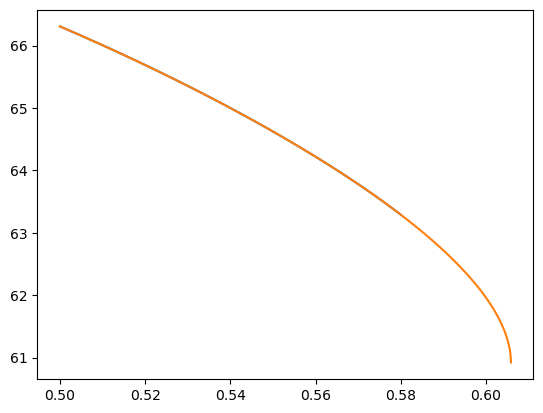

In [33]:
xplot = np.linspace(0.5, 0.58, 100)
Tplot = [T_prof(x) for x in xplot]
plt.plot(xplot, Tplot)
plt.plot(vsol.y[2][0:xi_max_index+1], vsol.y[1][0:xi_max_index+1])

In [34]:
xsh=optimize.brentq(lambda x: μ(x, v_prof(x))*x - cs_sq(Vtot, T_prof(x), hv), 0.5, xi_max*0.999)
xsh

0.6013272537273485

In [35]:
T_prof(xsh)

array(61.82340948)

In [57]:
def find_Tsh(Tm):
    guess_sol = optimize.fsolve(lambda x:match(x[0], 0.5, x[1], Tm,m.TnTrans[0]['high_vev'], m.TnTrans[0]['low_vev']),[0.1, m.TnTrans[0]['Tnuc']])
    vsol=integrate.solve_ivp(dYda, (10,0.01), np.array([μ(0.5, guess_sol[0]), guess_sol[1], 0.5]),t_eval=np.linspace(10,0.01,1000),method='DOP853',args=(Vtot, hv))
    xi_max = vsol.y[2].max()
    xi_max_index = vsol.y[2].argmax()
    v_prof = interpolate.interp1d(vsol.y[2][0:xi_max_index+1],vsol.y[0][0:xi_max_index+1])
    T_prof = interpolate.interp1d(vsol.y[2][0:xi_max_index+1],vsol.y[1][0:xi_max_index+1])
    xsh=optimize.brentq(lambda x: μ(x, v_prof(x))*x - cs_sq(Vtot, T_prof(x), hv), 0.5, xi_max*0.9999)
    return T_prof(xsh)

In [58]:
find_Tsh(55)

array(58.32940369)

In [67]:
Tmax = m.TnTrans[0]['Tnuc']
Tmin = 58
for i in range(30):
    Tcal=(Tmax+Tmin)/2
    Tsh = find_Tsh(Tcal)
    if Tsh < m.TnTrans[0]['Tnuc']:
        Tmin = Tcal
    else:
        Tmax = Tcal

In [64]:
Tcal

59.962963788577525

In [68]:
find_Tsh(Tcal)

array(61.79613023)

In [42]:
m.TnTrans[0]['Tnuc']

61.79608446346483

In [72]:
Tm = Tcal
vp, Tp = optimize.fsolve(lambda x:match(x[0],0.5,x[1], Tcal, hv, lv),[0.3, Tnuc], xtol=1e-10)
print(vp, Tp)

0.31047522909752345 66.27942104150685


## Solve the temperature variation and field value profile

In [77]:
print(lv, hv)

[202.04374412 482.78409962] [9.51180104e-06 1.78261369e+02]


In [79]:
h0 = lv[0]
s0 = lv[1]-hv[1]
s_initial=hv[1]

In [172]:
def h_profile(z,Lh):
    z = np.asanyarray(z)
    hz = 0.5*h0*(1-np.tanh(z/Lh))
    return hz

def s_profile(z, Ls, deltas):
    z = np.asanyarray(z)
    sz = 0.5*s0*(1-np.tanh(z/Ls + deltas)) + s_initial
    return sz

In [173]:
integrate.quad(lambda z: m.gradV([h_profile(z, 1.0), s_profile(z, 1.0, 5)],60)[0], -50, 50)

(2875995.5076784138, 0.041634234009750165)

### Solve the temperature profile following the field value profile

In [176]:
c1 = w(Vtot, Tp, hv) * vp/(1-vp**2)
s1=c1
c2=-Vtot(hv, Tp) + w(Vtot, Tp, hv) * vp**2 /(1-vp**2)
s2=c2

In [178]:
def T33(T,z, Lh, Ls, deltas):
    derh = derivative(lambda zvalue: h_profile(zvalue,Lh),z)
    ders = derivative(lambda zvalue: s_profile(zvalue,Ls,deltas),z)
    field_value = [h_profile(z, Lh), s_profile(z, Ls, deltas)]
    return 0.5*(derh**2 + ders**2) - Vtot(field_value, T) - 0.5*w(Vtot, T, field_value) + 0.5*(4*s1**2 + w(Vtot, T, field_value)**2)**0.5 - s2

In [208]:
Tplot = np.linspace(55, 70, 100)
T33plot = [T33(T, -10,1.0,1.0,5.0) for T in Tplot]

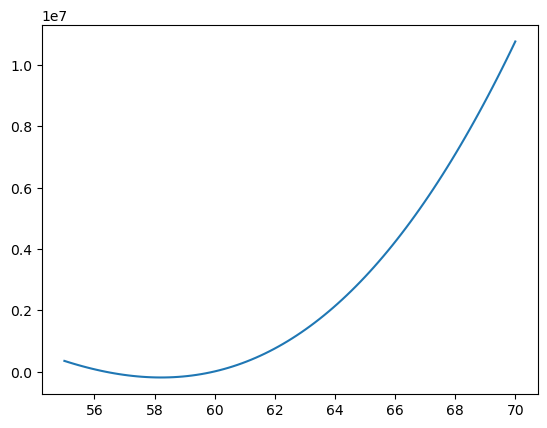

In [209]:
plt.plot(Tplot, T33plot)

In [200]:
optimize.fsolve(lambda T: T33(T[0], 0.2, 1.0, 1.0, 5.0), 66)

array([66.48024827])

In [216]:
zplot = np.linspace(-20,20,1000)
Tplot = [optimize.fsolve(lambda T: T33(T[0], z, 1.0, 1.0, 5.0), 60)[0] for z in zplot]

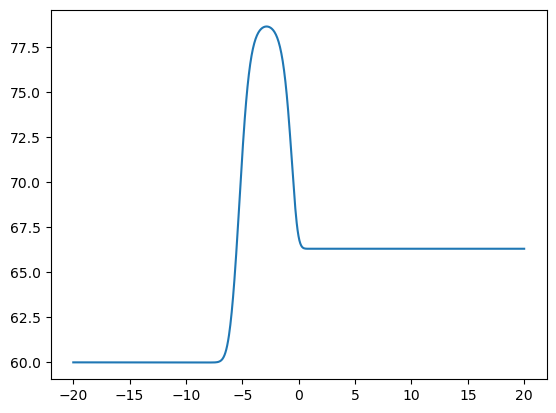

In [217]:
plt.plot(zplot, Tplot)

In [225]:
T_prof = interpolate.interp1d(zplot, Tplot, kind='cubic')

In [236]:
Lh = 1.0
Ls = 1.0
deltas = 5.0
Eh = lambda z: m.gradV([h_profile(z, Lh), s_profile(z, Ls, deltas)], T_prof(z))[0]
Sech = lambda x: 1/np.cosh(x)
hprime = lambda z: -0.5*(lv[0]*Sech(z/Lh)**2)/Lh

In [237]:
integrate.quad(lambda z: -Eh(z) * hprime(z), -20, 20)

(40600182.05008823, 0.48888518822334304)

In [247]:
def moments(Lh, Ls, deltas):
    z_range = np.linspace(-10*max(Lh,Ls), 10*max(Lh,Ls), 500)
    zmin, zmax = z_range[0], z_range[-1]
    T_sol = [optimize.fsolve(lambda T: T33(T[0], z, Lh, Ls, deltas), Tnuc)[0] for z in z_range]
    T_prof = interpolate.interp1d(z_range, T_sol, kind='cubic')
    Eh = lambda z: m.gradV([h_profile(z, Lh), s_profile(z, Ls, deltas)], T_prof(z))[0]
    Es = lambda z: m.gradV([h_profile(z, Lh), s_profile(z, Ls, deltas)], T_prof(z))[1]
    hprime = lambda z: -0.5*(h0*Sech(z/Lh)**2)/Lh
    sprime = lambda z: -0.5*(s0*Sech(deltas + z/Ls)**2)/Ls
    Ph = integrate.quad(lambda z: - Eh(z) * hprime(z), zmin, zmax)[0]
    Gh = integrate.quad(lambda z: - Eh(z) * hprime(z) * np.tanh(z/Lh), zmin, zmax)[0]
    Ps = integrate.quad(lambda z: - Es(z) * sprime(z), zmin, zmax)[0]
    Gs = integrate.quad(lambda z: - Es(z) * sprime(z) * np.tanh(z/Ls + deltas), zmin, zmax)[0]
    return np.array([Ph, Ps, Gh, Gs])

In [252]:
moments(1.5, 1.5, 4)

array([ 40404927.42144436, -37499297.4864777 , -24414990.77869301,
        -6131067.2355764 ])

In [256]:
def moment_min(L):
    Lh = L[0]
    Ls = L[1]
    deltas = L[2]
    Ph, Ps, Gh, Gs = moments(Lh, Ls, deltas)
    return (Ph-Ps)**2 + Gh**2 + Gs**2

In [242]:
def moment_match(Lh, Ls, deltas):
    Ph, Ps, Gh, Gs = moments(Lh, Ls, deltas)
    return [Ph-Ps, Gh, Gs]

In [246]:
optimize.fsolve(lambda L: moment_match(L[0], L[1], L[2]), [1.0, 1.0, 5.0])

/Users/quarkquartet/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


array([-177.24647677, -170.61162837, -448.08816308])

In [250]:
moments(177.24647677, 170.61162837, -448.08816308)

array([-34212365.44344092,         0.        ,   3365024.03471949,
              -0.        ])

In [257]:
optimize.minimize(moment_min, [0.3,0.3, 100])

/Users/quarkquartet/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/quarkquartet/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/Users/quarkquartet/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/quarkquartet/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 2257510152639507.5
        x: [ 3.000e-01  3.000e-01  1.000e+02]
      nit: 0
      jac: [ 3.238e+12 -2.087e+11  0.000e+00]
 hess_inv: [[1 0 0]
            [0 1 0]
            [0 0 1]]
     nfev: 128
     njev: 30